# Import Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os #For handling file directory
import shutil
import random
import uuid
import hashlib #To detect duplicate images
from PIL import Image #To detect corrupt files
from sklearn.utils import class_weight
from pathlib import Path
from math import ceil

# Data Loading and Splitting

In [11]:
# PARAMETERS
DATASET_DIR = r"C:\Users\DELL\Documents\CTS_classification\CTS_Datasets\Datasets"
SPLIT_DIR = r"C:\Users\DELL\Documents\CTS_classification\Data_split"
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
RANDOM_SEED = 42
IMG_SIZE = (300, 300)

IMAGE_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}

In [12]:
def is_image_file(fname):
    return Path(fname).suffix.lower() in IMAGE_EXTENSIONS

def make_dirs():
    for split in ["train", "val", "test"]:
        os.makedirs(os.path.join(SPLIT_DIR, split), exist_ok=True)

In [13]:
def stratified_split():
    random.seed(RANDOM_SEED)
    make_dirs()

    classes = [d for d in sorted(os.listdir(DATASET_DIR)) if os.path.isdir(os.path.join(DATASET_DIR, d))]
    if not classes:
        raise ValueError(f"No class subfolders found in {DATASET_DIR}")

    print("Classes found:", classes)

    for cls in classes:
        src_cls_dir = os.path.join(DATASET_DIR, cls)
        files = [f for f in sorted(os.listdir(src_cls_dir)) if is_image_file(f)]
        random.shuffle(files)

        n_total = len(files)
        n_train = int(TRAIN_RATIO * n_total)
        n_val = int(VAL_RATIO * n_total)

        train_files = files[:n_train]
        val_files = files[n_train:n_train + n_val]
        test_files = files[n_train + n_val:]

        for split_name, split_files in zip(["train", "val", "test"], [train_files, val_files, test_files]):
            out_dir = os.path.join(SPLIT_DIR, split_name, cls)
            os.makedirs(out_dir, exist_ok=True)
            for fname in split_files:
                src = os.path.join(src_cls_dir, fname)
                dst = os.path.join(out_dir, fname)
                shutil.copy2(src, dst)

        print(f"Class '{cls}': total={n_total} -> train={len(train_files)}, val={len(val_files)}, test={len(test_files)})")

    print('\n Split complete. Folders created under', SPLIT_DIR)
stratified_split()

Classes found: ['Grade A', 'Grade B', 'Impurities']
Class 'Grade A': total=1085 -> train=868, val=108, test=109)
Class 'Grade B': total=1004 -> train=803, val=100, test=101)
Class 'Impurities': total=34 -> train=27, val=3, test=4)

✅ Split complete. Folders created under C:\Users\DELL\Documents\CTS_classification\Data_split


# Data Augmentation for the Impurity Class

In [ ]:
# Define params
TARGET_SIZE = (300, 300)
N_TARGET    = 600 

def augment_minority_class(minority_class="Impurity", n_target=N_TARGET):
    aug_impurities_dir = os.path.join(SPLIT_DIR, "train", minority_class)

    if not os.path.exists(aug_impurities_dir):
        print(f"Minority class folder not found: {aug_impurities_dir}")
        return

    n_current = len([f for f in os.listdir(aug_impurities_dir) if is_image_file(f)])
    n_generate = n_target - n_current
    print(f"\nClass '{minority_class}' before augmentation: {n_current} images")

    if n_generate <= 0:
        print(f" No augmentation needed. Already has {n_current} images.")
        return

    # Data augmentation setup
    datagen = ImageDataGenerator(
        rotation_range=25,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.08,
        zoom_range=0.12,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    generator = datagen.flow_from_directory(
        directory=os.path.join(SPLIT_DIR, "train"),
        classes=[minority_class],
        target_size=TARGET_SIZE,
        batch_size=1,
        save_to_dir=aug_impurities_dir,   # save here
        save_prefix="aug",
        save_format="jpg"
    )

    # Generate and save new images
    for i in range(n_generate):
        next(generator)

    # Count final images
    final_count = len([f for f in os.listdir(aug_impurities_dir) if is_image_file(f)])
    print(f"✅ Augmented '{minority_class}' to {final_count} images.\n")
augment_minority_class(minority_class="Impurity", n_target=N_TARGET)

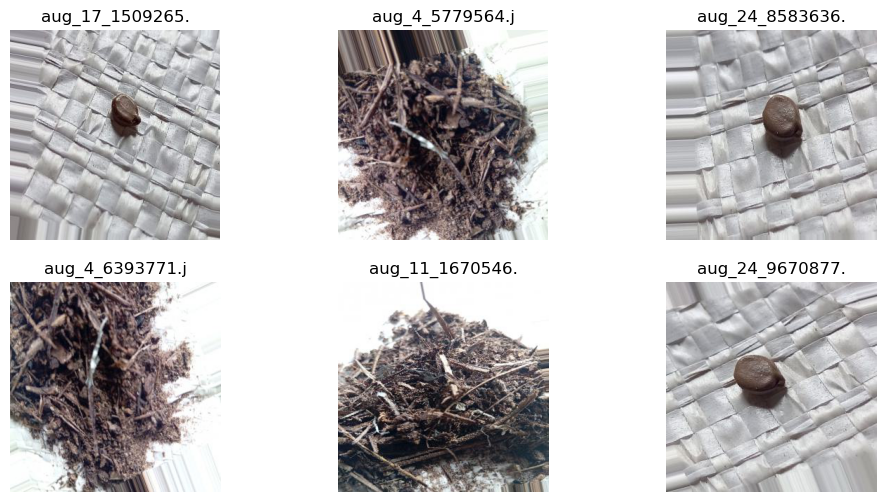

In [24]:
#Visualize augmented Class
folder = os.path.join(SPLIT_DIR, "train", "Impurities")  # change to your class
sample_imgs = random.sample(os.listdir(folder), 6)

plt.figure(figsize=(12, 6))
for i, img_name in enumerate(sample_imgs):
    img = mpimg.imread(os.path.join(folder, img_name))
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(img_name[:15])  
plt.show()


In [27]:
# Check class distreibution
import pandas as pd

dist = {}
for split in ["train", "val", "test"]:
    split_path = os.path.join(SPLIT_DIR, split)
    dist[split] = {cls: len(os.listdir(os.path.join(split_path, cls))) 
                   for cls in os.listdir(split_path)}
print(pd.DataFrame(dist))

            train  val  test
Grade A       868  108   109
Grade B       803  100   101
Impurities    591    8     8


In [28]:
# Preprocess Images in Train directory
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.08,
    zoom_range=0.12,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

In [29]:
# Load Data Into Generatorr
train_generator = train_datagen.flow_from_directory(
    os.path.join(SPLIT_DIR, "train"),
    target_size=(300, 300),
    batch_size=32,
    class_mode="categorical"
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(SPLIT_DIR, "val"),
    target_size=(300, 300),
    batch_size=32,
    class_mode="categorical"
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(SPLIT_DIR, "test"),
    target_size=(300, 300),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

Found 2262 images belonging to 3 classes.
Found 216 images belonging to 3 classes.
Found 218 images belonging to 3 classes.


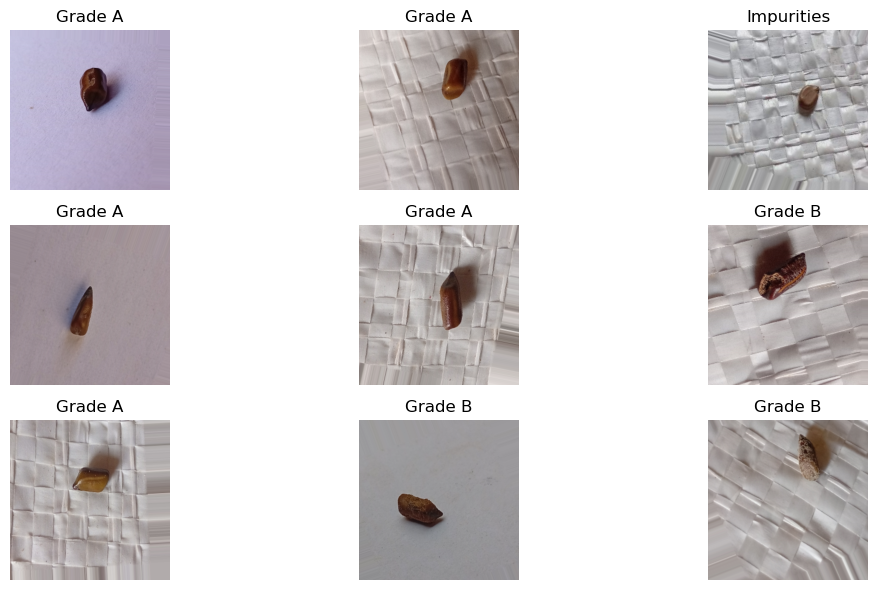

In [30]:
# Visualise Resized Images
def visualize_generator(generator, class_names=None, n_images=9):
    images, labels = next(generator)  # get 1 batch
    if class_names is None:
        class_names = {v: k for k, v in generator.class_indices.items()}

    plt.figure(figsize=(12, 6))
    for i in range(min(n_images, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        label_idx = labels[i].argmax()
        plt.title(class_names[label_idx])
        plt.axis("off")
    plt.tight_layout()
    plt.show()
visualize_generator(train_generator)

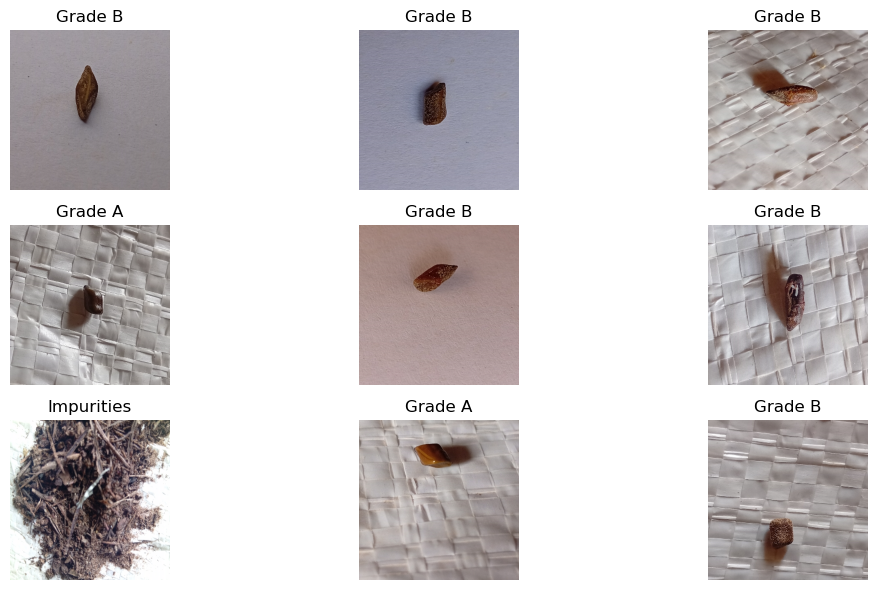

In [31]:
visualize_generator(val_generator)

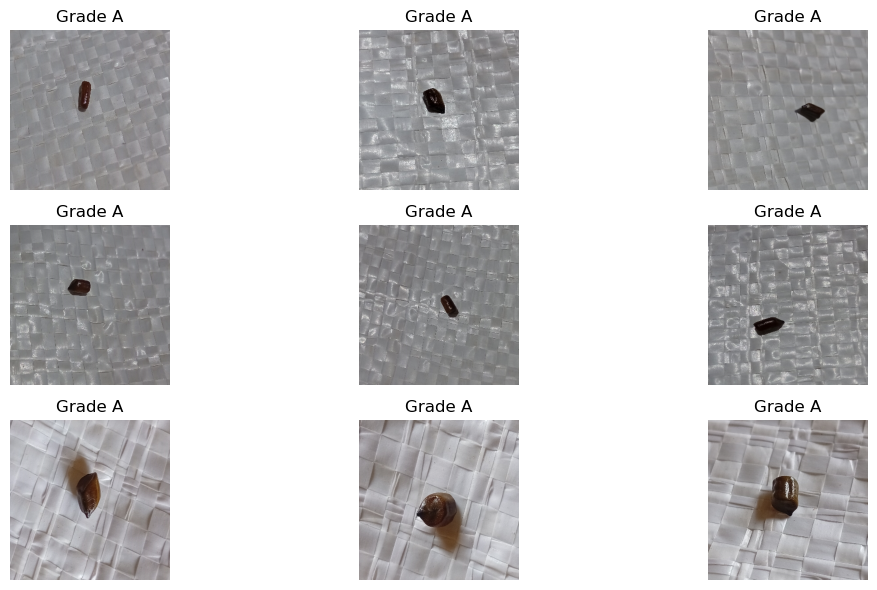

In [32]:
visualize_generator(test_generator)

# Build The Model

In [36]:
from tensorflow.keras.applications import MobileNetV2, EfficientNetB3
from tensorflow.keras.models import Sequential

# Training Parameters
IMG_SIZE = (300, 300)
LR = 1e-5
EPOCHS = 20
N_CLASSES = 3

In [37]:
# Build MobileNetV2 Model
def build_mobilenetv2(input_shape=IMG_SIZE + (3,), n_classes=N_CLASSES):
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights="imagenet"
    )
    base_model.trainable = False  # freeze base layers

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.3),
        Dense(128, activation="relu"),
        Dropout(0.3),
        Dense(n_classes, activation="softmax")
    ])

    model.compile(
        optimizer=Adam(learning_rate=LR),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Train Model

In [38]:
mobilenet_model = build_mobilenetv2()

print("Training MobileNetV2...")
history_mobilenet = mobilenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)


C:\Users\DELL\AppData\Local\Temp\ipykernel_1688\1986688414.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 18s 2us/step
Training MobileNetV2...


C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 316s 4s/step - accuracy: 0.3165 - loss: 1.4516 - val_accuracy: 0.3704 - val_loss: 1.1037
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 294s 4s/step - accuracy: 0.4549 - loss: 1.1184 - val_accuracy: 0.6852 - val_loss: 0.8560
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 285s 4s/step - accuracy: 0.5517 - loss: 0.9080 - val_accuracy: 0.7778 - val_loss: 0.7170
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 290s 4s/step - accuracy: 0.6393 - loss: 0.7886 - val_accuracy: 0.8056 - val_loss: 0.6272
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 481s 7s/step - accuracy: 0.6901 - loss: 0.7210 - val_accuracy: 0.8287 - val_loss: 0.5603
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 398s 6s/step - accuracy: 0.7281 - loss: 0.6525 - val_accuracy: 0.8333 - val_loss: 0.5083
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 839s 12s/step - accuracy: 0.7692 - loss: 0.6003 - val_accuracy: 0.8472 - val_loss: 0.4682
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 674s 9s/step - accuracy: 0.7790 - loss: 0.5493 - val_accuracy: 0.8565 - 

KeyboardInterrupt: 

In [40]:
# Save Model
mobilenet_model.save("mobilenetv2_model.keras")

In [41]:
# Load Model
from tensorflow.keras.models import load_model
mobilenet_loaded = load_model("mobilenetv2_model.keras")

C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [42]:
# Evaluate accuracy and loss
test_loss, test_acc = mobilenet_loaded.evaluate(test_generator, verbose=1)
print(f" MobilenetV2 Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 71s 9s/step - accuracy: 0.8624 - loss: 0.3918
 MobilenetV2 Test Accuracy: 0.8624, Test Loss: 0.3918


In [43]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Test a single image
img_path = r"C:\Users\DELL\Documents\CTS_classification\Data_split\test\Grade B\IMG_20250703_101915.jpg"
img = image.load_img(img_path, target_size=(300, 300))  # match TARGET_SIZE
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # normalize

# Predict
pred = mobilenet_loaded.predict(img_array)
class_idx = np.argmax(pred, axis=1)[0]
class_labels = list(train_generator.class_indices.keys())  # same order as training
print("Predicted class:", class_labels[class_idx])


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: Grade B


In [46]:
# Metrics for Predict classes
y_pred = mobilenet_loaded.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_hat = test_generator.classes

# Class labels
class_labels = list(test_generator.class_indices.keys())

# Classification report
print("\nClassification Report (MobileNetV2):\n")
print(classification_report(y_hat, y_pred_classes, target_names=class_labels))

7/7 ━━━━━━━━━━━━━━━━━━━━ 69s 9s/step

Classification Report (MobileNetV2):

              precision    recall  f1-score   support

     Grade A       0.88      0.84      0.86       109
     Grade B       0.84      0.91      0.87       101
  Impurities       1.00      0.50      0.67         8

    accuracy                           0.86       218
   macro avg       0.91      0.75      0.80       218
weighted avg       0.87      0.86      0.86       218



# INTERPRETATION

1. <b>Overall Performance</b><br>

~ Accuracy: 86%
~ Weighted F1-score: 0.86

The model achieves a strong overall accuracy, correctly classifying the majority of test images. Performance is consistent across the two major classes (Grade A and Grade B), but shows limitations in detecting the minority class (Impurities).

2. <b>Per-class Metrics</b><br>
~ Grade A: High precision and recall balance. The model identifies most Grade A images but occasionally confuses them with Grade B.<br>
~ Grade B: Strong recall (91%), meaning most Grade B images are detected, though slightly lower precision indicates some misclassification from other classes.<br>
~ Impurities: Perfect precision (1.00) — the model never falsely predicts impurities. However, recall (0.50) is low, meaning the model misses half of the true impurities.

3. <b>Macro vs. Weighted Averages</b><br>
~ Macro Average: Precision = 0.91, Recall = 0.75, F1 = 0.80
- Treats all classes equally, highlighting weak recall on Impurities.

~ Weighted Average: Precision = 0.87, Recall = 0.86, F1 = 0.86
- Accounts for class imbalance, better reflects overall performance

<b> Key Insights<b/><br>

The model generalises well to Grades A and B, which have larger training samples. And the minority class, Impurities, suffers from low recall due to limited training data. The model is overly conservative, only predicting Impurities when highly confident.

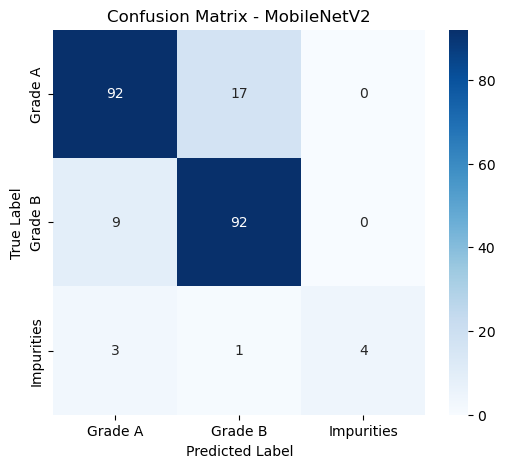

In [47]:
#confusion matrix
cm = confusion_matrix(y_hat, y_pred_classes)

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_labels, 
            yticklabels=class_labels)

plt.title("Confusion Matrix - MobileNetV2")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
